# Model Preparation using SageMaker APIs

## Introduction

This is a sample jupyter notebook that explains how to use Ambarella's Model Preperation Service using AWS SageMaker Python APIs. 
Users can subscribe to the algorithm from the product listing page: 
[Ambarella MPS](https://aws.amazon.com/marketplace/pp/prodview-b6kcmli2ly6ji)

The algorithm published does Object Detection on user's dataset. There are 2 components to SageMaker: 

**1. Preparing the model:**<br> 
Users are provided with options for hyper-parameters allowing them to train the model for their dataset. The output of training is Ambarella's proprietary AmbaPB fast checkpoint. 

**2. Running Inference:**<br> 
Users can run batch transforms or real time predictions on the output of training. The inference does the detection and outputs in application/json format which contains the boxes, scores and labels output. 

## Preparing the data

The training and validation dataset must follow certain rules as stated below: 

> train_dir/     
>> labels.json    
>> data/         
>>> filename0.jpg    
>>> filename1.jpg    
>>> ...

> val_dir/     
>> labels.json    
>> data/         
>>> filename0.jpg    
>>> filename1.jpg    
>>> ...

The label file must follow the COCO definition (Reference: https://cocodataset.org/#format-data) as mentioned in the next cell

In [1]:
JSON = {
    "info": {'xxx'},
    "licenses": [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        }
    ],
    "categories": [
        {
            "id": 2,
            "name": "cat",
            "supercategory": "animal",
            "keypoints": ["nose", "head", ...],
            "skeleton": [[12, 14], [14, 16], ...]
        }
    ],
    "images": [
        {
            "id": 1,
            "license": 1,
            "file_name": "<filename0>.jpg",
            "height": 480,
            "width": 640,
            "date_captured": "null"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 2,
            "bbox": [260, 177, 231, 199],
            "segmentation": [...],
            "keypoints": [224, 226, 2, ...],
            "num_keypoints": 10,
            "score": 0.95,
            "area": 45969,
            "iscrowd": 0
        }
    ]
}

## Run Training

Training requires the following: 
1. SageMaker python package installed.<br>
2. Hyper-parameters as dictionary<br>
3. Instance type<br>
4. Subscription to Ambarella's algorithm<br>
5. Access to S3 location for input and output data exchanges<br>

### Install sagemaker python API

In [ ]:
!python3 -m pip install sagemaker

#### Import packages

In [3]:
from sagemaker.estimator import Estimator
import boto3
import json
import enum
from util import *
import tarfile
from IPython.display import Image as display_image
import cv2

### Describe Hyperparameters

In [4]:
hyperparameters = {
    
    "batch_size":"8",
    "weight_decay":"0.0005",
    "num_classes":"21",
    "compression_level":"1",
    "eps":"1e-8",
    "monitor":"val_acc",
    "early_stopping":"True",
    "num_workers":"4",
    "momentum":"0.9",
    "lr_scheduler_factor":"0.1",
    "min_delta":"0.002",
    "lr_scheduler":"MultiStepLR",
    "optimizer":"sgd",
    "patience":"5",
    "backbone":"vgg16",
    "compression":"True",
    "epochs":"1",
    "learning_rate":"0.00004",
    "step_size":"20",
    "nms_thresh":"0.45",
    "iou_thresh":"0.5",
    "milestones":"50,70"
}

### Providing path to S3 location for train & val data

In [5]:
# Set the path to training and validation dataset 
input_data = {
            'train':'s3://<user_path>/train/',  
            'val':'s3://<user_path>/val/'
            }


### Call the estimator API and create an estimator object

Create a role on AWS IAM to allow access to SageMaker<br>
Provide a GPU instance such as ml.p2.xlarge to run training.<br>
Provide the image_uri to the subscribed algorithm


In [6]:
# Call the estimator API with role, image_uri, hyper-parameters, s3 path.

estimator = Estimator(
    role='arn:aws:iam::user_account:role/SageMakerTraining',
    instance_count=1,
    instance_type='ml.p2.xlarge',
    image_uri='subscribed_uri',
    hyperparameters=hyperparameters,
    output_path='s3://<output_path>',
    base_job_name='test-notebook'
)


INFO: 03/07/2022 14:35:12.005847 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


###  Call the fit() API to start training on AWS instances

In [ ]:
estimator.fit(input_data)

### Monitor metrics

Training log can be monitored here in the console or SageMaker console. <br>
Instance and algorithm metrics can be monitored on the SageMaker console.

## Running Inference

![title](sagemaker.jpg)

Inference involves creating an endpoint and sending image/jpg requests which runs forward pass on the model artifacts and streams back application/json response<br>

There are 2 ways of running inference. 

1. Using the SageMaker APIs
2. Using CVFlow APIs

### Select the image to run inference on

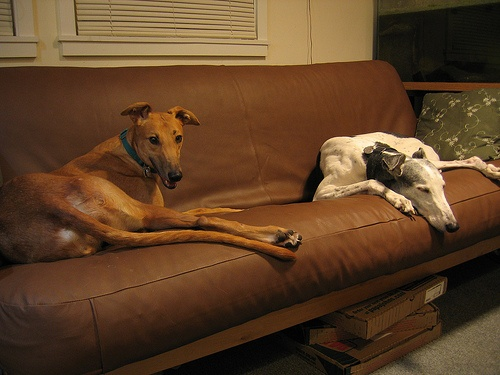

In [8]:
# Loading a few image samples
class Images(enum.Enum):
    img_1 = '000001.jpg'
    img_2 = '000005.jpg'
    img_3 = '000108.jpg'
    
    
image_file = Images.img_3.value
display_image(image_file)

### 1. Running Inference using SageMaker APIs

The sample code below shows how to use sagemaker's runtime API. 

#### 1.1. Instantiate SageMaker runtime

In [9]:
runtime = boto3.Session().client(service_name='sagemaker-runtime')

INFO: 03/07/2022 15:39:49.840124 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


#### 1.2. Deploy & Get endpoint name

It is required to deploy the model and get the endpoint name of the model <br>
There are 2 options: 

1. Use the deploy python API and get the endpoint name
2. On the SageMaker console, create a Model with endpoint configuration under the Inference section



#### 1.2.1 Using deploy API

In [10]:
# Deploys the model that was generated by fit() to a SageMaker endpoint
deploy = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')
endpoint_name = deploy.endpoint_name

INFO: 03/07/2022 15:39:50.682997 session.py:2660 [cvflowbackend] Creating model with name: test-notebook-2022-03-07-23-39-50-502
INFO: 03/07/2022 15:39:50.964425 session.py:3541 [cvflowbackend] Creating endpoint-config with name test-notebook-2022-03-07-23-39-50-502
INFO: 03/07/2022 15:39:51.045426 session.py:3034 [cvflowbackend] Creating endpoint with name test-notebook-2022-03-07-23-39-50-502


----------------!

#### 1.2.2 Using SageMaker console

In [11]:
# Create Model under inference section on the SageMaker console
endpoint_name = 'xxx'

#### 1.3. Load the image

In [12]:
img = open(image_file, 'rb').read()

#### 1.4. Call the runtime API and read the response.

In [13]:
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='image/jpg', 
    Body=bytearray(img)
)

# Read the `Body` of the response (in application/json format)
result = response['Body'].read()

# Load the result into a dictionary
res_dict = json.loads(result)

#### 1.5. Get the box, scores and labels and display the image

[0.98780173 0.9006392  0.8925471 ]
3


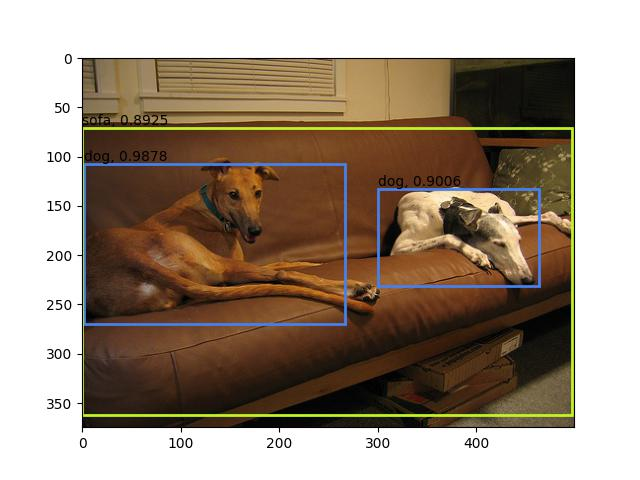

In [14]:
bboxes = np.asarray(res_dict['bboxes'][0], dtype=np.float32)
scores = np.asarray(res_dict['scores'][0], dtype=np.float32)
labels = np.asarray(res_dict['labels'][0], dtype=np.int32)

output_image_file = draw_bbox(image_file, bboxes, scores, labels)
display_image(output_image_file)

### 2. Running Inference using CVFlow APIs

Running inference is also possible on the model artifacts directly if user has access to Ambarella's CVTOOLS.<br>

Inference involves the following: 
1. Retrieve the model from S3 output path
2. Load the fast checkpoint
3. Create an Inference Session 
4. Load the image
5. Call sess.run()

In [15]:
from cvflowbackend.evaluation_stage import InferenceSession

#### 2.1. Retrieve the model from S3

In [16]:
BUCKET_NAME = 'bucket_name'
KEY = '<user_path>/output/model.tar.gz'

s3 = boto3.resource('s3')
s3.Bucket(BUCKET_NAME).download_file(KEY, 'model.tar.gz')

INFO: 03/07/2022 15:48:25.876113 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


In [17]:
output = tarfile.open('model.tar.gz')
output.extractall()
fast_checkpoint = "output/primitive.ambapb.fastckpt.onnx"

#### 2.2 Create an Inference session

In [18]:
# Inference session
sess = InferenceSession(fast_checkpoint, mode="acinf", cuda_devices=0)
i_configs = sess.get_input_configs()

INFO: 03/07/2022 15:48:33.555305 logging.py:314 [Eval Stage] ---------------------------------------------------------------
INFO: 03/07/2022 15:48:33.557535 logging.py:314 [Eval Stage] ---------------- Initializing InferenceSession ----------------
INFO: 03/07/2022 15:48:33.558389 logging.py:314 [Eval Stage] ---------------------------------------------------------------
INFO: 03/07/2022 15:48:36.989643 __init__.py:114 [Eval Stage] Created runtime MetaNode: ONNX(pre_process, engine=native)
INFO: 03/07/2022 15:48:36.990950 __init__.py:115 [Eval Stage]   inputs -> ['input']
INFO: 03/07/2022 15:48:36.991778 __init__.py:116 [Eval Stage]   outputs -> ['107', '135', '138', '233']
INFO: 03/07/2022 15:48:37.006398 orcvpcontext.py:194 [Eval Stage] Writing primitive graph json: /tmp/tmpo1lh4rsp_feature_extractor_pid_83446/feature_extractor.json
INFO: 03/07/2022 15:48:37.028685 orcvpcontext.py:200 [Eval Stage] Writing 244 primitive graph immediates
INFO: 03/07/2022 15:48:37.490058 ambacnn_helper

#### 2.3 Create a feed dict for an input image

In [19]:
feed_dict = {}
model_input_shape_tuple = (i_configs[0].shape[2], i_configs[0].shape[3])
img_array = read_image(image_file, model_input_shape_tuple)
feed_dict[i_configs[0].name] = [img_array]

#### 2.4 Load the image and run forward pass

In [20]:
# Load inputs
sess.set_inputs(feed_dict)

# Run forward pass
res_dict = sess.run()

INFO: 03/07/2022 15:48:37.668532 ambacnnop.py:85 [Eval Stage] VP(feature_extractor, engine=acinference) config: forward_quantized=False, dump_quantized=True
INFO: 03/07/2022 15:48:37.669862 __init__.py:186 [Eval Stage] ********************************************************
INFO: 03/07/2022 15:48:37.670722 __init__.py:187 [Eval Stage] * Running context 1/3 ONNX(pre_process, engine=native) *
INFO: 03/07/2022 15:48:37.671506 __init__.py:188 [Eval Stage] ********************************************************
INFO: 03/07/2022 15:48:37.815236 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 0.143s, throughput: 6.994/s.
INFO: 03/07/2022 15:48:37.816224 __init__.py:186 [Eval Stage] *****************************************************************
INFO: 03/07/2022 15:48:37.816967 __init__.py:187 [Eval Stage] * Running context 2/3 VP(feature_extractor, engine=acinference) *
INFO: 03/07/2022 15:48:37.817685 __init__.py:188 [Eval Stage] *****************************************

opened session 6536 on libambacnn cv2.qa.2022-03-06.1265.cuda9.2 (70bc231*0), at 2022-03-07 15:48:40
libambacnn session config: target_device = cv2, gpu_id = 0, mode = default, split = False


INFO: 03/07/2022 15:48:42.675325 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 4.857s, throughput: 0.206/s.
INFO: 03/07/2022 15:48:42.677029 __init__.py:186 [Eval Stage] *****************************************************
INFO: 03/07/2022 15:48:42.677973 __init__.py:187 [Eval Stage] * Running context 3/3 ONNX(detector, engine=native) *
INFO: 03/07/2022 15:48:42.678709 __init__.py:188 [Eval Stage] *****************************************************
INFO: 03/07/2022 15:48:42.791855 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 0.112s, throughput: 8.896/s.


#### 2.5 Draw bbox and display the image

[0.98780185 0.9006386  0.89254713]
3


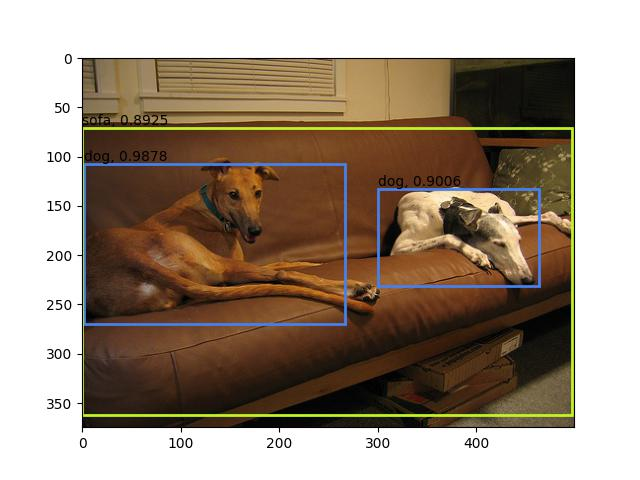

In [21]:
bboxes = np.asarray(res_dict['bboxes'][0], dtype=np.float32)
scores = np.asarray(res_dict['scores'][0], dtype=np.float32)
labels = np.asarray(res_dict['labels'][0], dtype=np.int32)

output_image_file = draw_bbox(image_file, bboxes, scores, labels)
display_image(output_image_file)